In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


***Step 1.*** *Import the required libraries.*

In [ ]:
# Data Visualization
import pandas as pd
import numpy as np
import seaborn as sns
import pandas_profiling as pp
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="whitegrid")

# Model
import imblearn
from sklearn import metrics
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import chi2
from scipy.stats import ttest_1samp, ttest_ind
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, GridSearchCV

# Metrics
import statsmodels.api as sm
import scipy.stats as st
from scipy.stats import chi2_contingency
from sklearn.metrics import r2_score, mean_squared_error

***Step 2.*** *Load the dataset.*

In [ ]:
wine_data = pd.read_csv('drive/My Drive/Colab Notebooks/csv_dataset/winequality-red.csv')
wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


_**Step 3.**_ *Assign x and y variables to independent x and y features.*

In [ ]:
X = wine_data.drop('quality', axis=1)
y = wine_data['quality']

In [ ]:
y.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

***Observation***    

*There is a class imbalance. 
This problem can be solved by applying **Synthetic Minority Oversampling Technique (SMOTE**)* 

***Step 4.*** *Apply Synthetic Minority Oversampling Technique.*

In [ ]:
oversample = SMOTE(random_state=0)
# transform the dataset
X_sm, y_sm = oversample.fit_resample(X, y)

In [ ]:
print("Before smote --> ", Counter(y))
print("After smote  --> ", Counter(y_sm))
X, y = X_sm, y_sm

Before smote -->  Counter({5: 681, 6: 638, 7: 199, 4: 53, 8: 18, 3: 10})
After smote  -->  Counter({5: 681, 6: 681, 7: 681, 4: 681, 8: 681, 3: 681})


***Step 5.*** *Standardize the data.*

In [ ]:
sc = StandardScaler()
sc.fit(X)

StandardScaler()

***Step 6.*** *Split into testing and training datasets*

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

### **Feature selection using chi-square test**

***Step 7.*** *Check for null values.*

In [ ]:
X_train.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
dtype: int64

***Step 8.*** *Use chi-square to get the 
f-score values and p-value*.  



In [ ]:
f_p_values = chi2(X_train, y_train)
f_p_values

(array([4.89892152e+01, 1.70108681e+02, 9.88479312e+01, 1.97225167e+01,
        9.72293091e+00, 1.44041506e+03, 9.59030963e+03, 1.69332959e-03,
        2.47791159e+00, 2.52838729e+01, 1.96025080e+02]),
 array([2.23054401e-009, 6.91694321e-035, 9.24330731e-020, 1.40875508e-003,
        8.34774952e-002, 2.40602011e-309, 0.00000000e+000, 9.99999994e-001,
        7.79817893e-001, 1.22803215e-004, 2.01191848e-040]))

In [ ]:
# change values
data = pd.crosstab(wine_data['quality'], wine_data['chlorides'])
# data = wine_data
stat, p, dof, expected = chi2_contingency(data)

alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
  print("Dependent (reject H0) - There is no significant differences")
else:
  print("Independent (H0 holds true) - There is significant differences")

p value is 1.1813496192507552e-34
Dependent (reject H0) - There is no significant differences


***Step 9.*** *Order the p values to get the most important feature among the columns.*

In [ ]:
p_values = pd.Series(f_p_values[1])
p_values.index = X_train.columns
p_values.sort_index(ascending=True)

alcohol                  2.011918e-40
chlorides                8.347750e-02
citric acid              9.243307e-20
density                  1.000000e+00
fixed acidity            2.230544e-09
free sulfur dioxide     2.406020e-309
pH                       7.798179e-01
residual sugar           1.408755e-03
sulphates                1.228032e-04
total sulfur dioxide     0.000000e+00
volatile acidity         6.916943e-35
dtype: float64

***Observation***  

*Alcohol column is the most important among the other features.* 

### **Feature selection using Pearson Correlation**

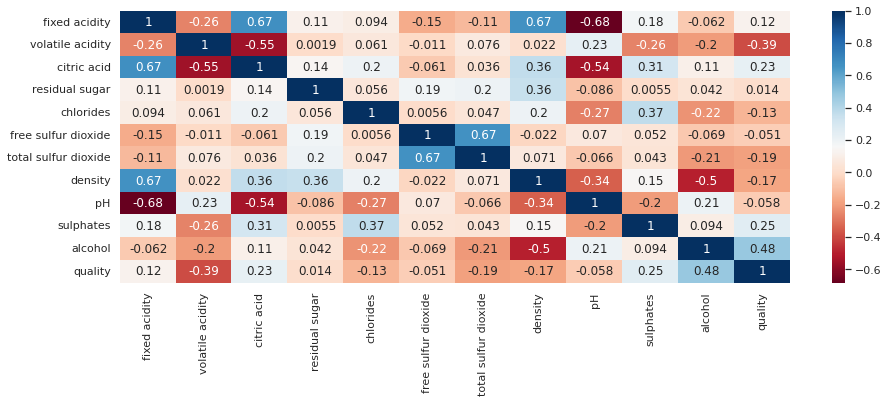

In [ ]:
plt.figure(figsize=(15, 5))
sns.heatmap(wine_data.corr(), annot=True, cmap='RdBu')
plt.show()

***Observation***    


  *1.* *fixed acidity has high correlation(>0.66) with density and citric acid and a negative correlation(<-0.69) with pH.*  
  *2.* *volatile acidity seems to have a negative effect on quality (-0.41).*  
  *3.* *free sulfur dioxide is more if total sulfur dioxide is more and vice versa.*  
  *4.* *alcohol is having influence on quality of wine.*  
  *5.* *alcohol and density have a negative correlation (-0.49*)  
  *6.* *pH, free and total sulfure dioxide, chlorides, residual sugar do not have high correlation on quality*
  
*Although correlation predicts that certain features(alcohol and pH) have a relationship with quality. The data does not establish a linear relationship between any of the features.*

***Step 10.*** *Define a function for correlation.*

In [ ]:
def correlation(dataset, threshold):
  col_corr = set()                                 # set of all the names of correlated columns
  corr_matrix = dataset.corr()
  for i in range(len(corr_matrix.columns)):
    for j in range(i):
      if abs(corr_matrix.iloc[i, j]) > threshold:  # we are interested in absolute coefficient value
        colname = corr_matrix.columns[i]           # getting the name of column/s
        col_corr.add(colname)
  return col_corr

***Step 11.*** *Use the features to see the correlated values.*

In [ ]:
# threshold : columns with .6 (could be any number) values. 
corr_features = correlation(X_train, .68)

In [ ]:
print(f"length: {len(set(corr_features))}")
print(f"columns: {corr_features}")

length: 3
columns: {'pH', 'total sulfur dioxide', 'citric acid'}


***Step 12.*** *Get the correlation of the two features.*

In [ ]:
# change values
print("Pearson correlation coefficient:", st.pearsonr(wine_data["alcohol"],
                                                      wine_data["quality"]))

Pearson correlation coefficient: (0.47616632400113607, 2.831476974778582e-91)


***Step 13.*** *Drop the highest correlated features.*

In [ ]:
X_train.drop(corr_features, axis=1)
X_test.drop(corr_features, axis=1)

,fixed acidity,volatile acidity,residual sugar,chlorides,free sulfur dioxide,density,sulphates,alcohol
3226,6.962788,0.768954,2.644186,0.073674,17.000000,0.995723,0.848140,12.132559
2226,7.227617,1.240718,1.975872,0.112588,5.413758,0.995273,0.495164,10.506929
2506,9.079912,0.491213,2.270711,0.092456,6.292889,0.997030,0.537573,10.263600
1947,10.383605,0.639553,1.946584,0.122909,11.520494,0.999257,0.554795,9.202733
3238,5.105062,0.515483,2.084815,0.042067,15.949385,0.992400,0.869663,12.901687
...,...,...,...,...,...,...,...,...
4082,10.692979,0.349960,2.598195,0.069982,4.995988,0.997198,0.650903,10.997994
720,8.400000,0.560000,2.000000,0.082000,10.000000,0.997600,0.440000,9.600000
1423,6.400000,0.530000,3.900000,0.123000,14.000000,0.996800,0.670000,11.000000
2347,9.263164,0.606201,3.184893,0.079924,6.000000,0.997607,0.540504,9.567050


### **T-test**

***Step 14.*** *Output the p values*

In [ ]:
_, p_value = st.ttest_ind(X, y, equal_var = True)
for i in p_value: print(i)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [ ]:
t2 = st.ttest_ind(X, y, equal_var = True)
print(t2)

Ttest_indResult(statistic=array([  77.649041  , -182.26740763, -194.14916657,  -88.08935951,
       -202.41999308,   51.14428067,   70.63155999, -168.53815212,
        -81.00540682, -180.32704592,  161.08041062]), pvalue=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))


## **Regression**



**Regression model with cross validation**

***Step 15.*** *Create a function for experiments. This function has different
k-values for cross validation, and it also outputs other metrics.* 

In [92]:
def reg_cross_val(model, X, y):
    # for cross validation
    K_value = [5, 10, 15, 20]

    # 80:20 split ratio
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
    # train the model
    model.fit(X_train, y_train) 
    # predict the model
    y_pred = model.predict(X_test)
    scores, pvalues = chi2(X_train, y_train) 

    print("Regression with Cross Validation\n")

    for i in range(len(K_value)):
      score = cross_val_score(model, X, y, cv = K_value[i], scoring  = "neg_mean_squared_error")
      print(f"K value ({K_value[i]}):", score.mean())

    # Mean value of the  predicted model vs the actual value               
    print("\nVariance    :", np.mean(y_pred-y_test))
    # Score of the testing model
    print("R2 score    :", r2_score(y_test, y_pred) * 100)
    # MSE / RMSE 
    print('RMSE\t    :', (mean_squared_error(y_test, y_pred)))
    # P-value
    print('P-value\t    :', np.mean(pvalues))

**Regression model without cross validation:**

Modify parameters:  
   Split ratio : 70:30 & 80:20  
   Random state: 0, 10, 20, 30 etc.

***Step 16.*** *Create another function for another experiment where cross validation is not applied.*

In [ ]:
def reg_no_cv(model, X, y):
    # different random state values
    r_state = [0, 10, 20, 30, 40, 50]
    parameters={'alpha': [1, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90]}

    print("Regression without Cross Validation\n")
    if (model == ridge) or (model == lasso):
      print(model)
      for i in range(len(r_state)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = r_state[i])
        modelcv = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error',cv=5)
        modelcv.fit(X_train, y_train)
        y_pred = modelcv.predict(X_test)

        data = {'Random State': r_state[i], 
                'Variance': np.mean(y_pred-y_test), 
                'R2 Score': round(r2_score(y_test, y_pred) * 100, 3),  
                'Best params': modelcv.best_params_,
                'Best score': modelcv.best_score_}

        print(' | '.join(f'{key}: {value}' for key, value in data.items()))

    elif (model == linear):
      print(model)
      print("70:30 Split Ratio")
      for i in range(len(r_state)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = r_state[i])
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        data = {'Random State': r_state[i], 
                'Variance': np.mean(y_pred-y_test), 
                'R2 Score': round(r2_score(y_test, y_pred) * 100, 3),
                'Random': r_state[i]}

        print(' | '.join(f'{key}: {value}' for key, value in data.items()))

      print("\n80:20 Split Ratio")
      for i in range(len(r_state)):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = r_state[i])
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        data = {'Random State': r_state[i], 
                'Variance': np.mean(y_pred-y_test), 
                'R2 Score': round(r2_score(y_test, y_pred) * 100, 3),
                'Random': r_state[i]}

        print(' | '.join(f'{key}: {value}' for key, value in data.items()))

### **Linear Regression**

***Step 17.*** *Call the function created above to get the results.*

In [ ]:
# linear regression with cross validation
linear = LinearRegression()
reg_cross_val(linear, X, y)

Regression with Cross Validation

K value (5): -1.2813583355035003
K value (10): -0.9542822122464829
K value (15): -0.8952927563683072
K value (20): -0.8747020483811114

Variance    : -0.00883570590288114
R2 score    : 71.00735401981072
RMSE	    : 0.8169696805745877
P-value	    : 0.16952972207059766


In [ ]:
reg_no_cv(model=linear, X=X, y=y)

Regression without Cross Validation

LinearRegression()
70:30 Split Ratio
Random State: 0 | Variance: -0.017848523850719108 | R2 Score: 71.797 | Random: 0
Random State: 10 | Variance: -0.00797074301427463 | R2 Score: 73.226 | Random: 10
Random State: 20 | Variance: -0.012693382866194232 | R2 Score: 70.015 | Random: 20
Random State: 30 | Variance: 0.047519030132215576 | R2 Score: 71.716 | Random: 30
Random State: 40 | Variance: -0.006856645906512523 | R2 Score: 72.953 | Random: 40
Random State: 50 | Variance: -0.009224523176412184 | R2 Score: 73.195 | Random: 50

80:20 Split Ratio
Random State: 0 | Variance: -0.00883570590288114 | R2 Score: 71.007 | Random: 0
Random State: 10 | Variance: -0.03763973811638261 | R2 Score: 72.946 | Random: 10
Random State: 20 | Variance: 0.010927092640207931 | R2 Score: 68.31 | Random: 20
Random State: 30 | Variance: 0.09079208328585714 | R2 Score: 72.568 | Random: 30
Random State: 40 | Variance: 0.009113992017092332 | R2 Score: 74.188 | Random: 40
Random 

In [87]:
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                quality   R-squared (uncentered):                   0.976
Model:                            OLS   Adj. R-squared (uncentered):              0.976
Method:                 Least Squares   F-statistic:                          1.517e+04
Date:                Sat, 22 Oct 2022   Prob (F-statistic):                        0.00
Time:                        13:51:52   Log-Likelihood:                         -5318.4
No. Observations:                4086   AIC:                                  1.066e+04
Df Residuals:                    4075   BIC:                                  1.073e+04
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
fixed acidity           -0.1093      0.016     -6.712      0.000      -0.141      -0.077
volatile acidity        -2.3626      0.094    -25.057      0.000      -2.547      -2.178
citric acid             -0.0442      0.146     -0.303      0.762      -0.330       0.241
residual sugar          -0.0748      0.012     -6.383      0.000      -0.098      -0.052
chlorides               -7.0307      0.391    -17.988      0.000      -7.797      -6.264
free sulfur dioxide      0.0035      0.002      1.595      0.111      -0.001       0.008
total sulfur dioxide    -0.0008      0.001     -0.995      0.320      -0.002       0.001
density                 10.7408      0.590     18.195      0.000       9.583      11.898
pH                      -3.2002      0.153    -20.929      0.000      -3.500      -2.900
sulphates                1.7287      0.113     15.365      0.000       1.508       1.949
alcohol                  0.6907      0.015     45.872      0.000       0.661       0.720
==============================================================================
Omnibus:                        3.331   Durbin-Watson:                   1.228
Prob(Omnibus):                  0.189   Jarque-Bera (JB):                3.363
Skew:                          -0.069   Prob(JB):                        0.186
Kurtosis:                       2.970   Cond. No.                     2.22e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.22e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Analysis:** 

*Comparing the results of the testing model with the training model, there is an **OVERFITTING** issue. The training model got a whopping percentage of 97.6% compared to its testing model that only got 71.01%. There is a need to optimize the error by implementing RIDGE or LASSO Regression.*

### **Ridge Regression**

In [89]:
ridge = Ridge(solver = "cholesky")
reg_cross_val(ridge, X, y)

Regression with Cross Validation

K value (5): -1.2957827039600534
K value (10): -0.9562469446780206
K value (15): -0.896125631160498
K value (20): -0.8755018569495517

Variance    : -0.02040574447233361
R2 score    : 71.62520541743145
RMSE	    : 0.8050175367162956
P-value	    : 0.17808351185090052


In [ ]:
reg_no_cv(ridge, X, y)

Regression without Cross Validation

Ridge(solver='cholesky')
Random State: 0 | Variance: -0.01055288639904702 | R2 Score: 71.051 | Best params: {'alpha': 1} | Best score: -0.8024581064169448
Random State: 10 | Variance: -0.03336946900675225 | R2 Score: 72.987 | Best params: {'alpha': 1} | Best score: -0.8076958043147249
Random State: 20 | Variance: 0.008371624503801047 | R2 Score: 68.306 | Best params: {'alpha': 1} | Best score: -0.7845481121841361
Random State: 30 | Variance: 0.0943403696266757 | R2 Score: 72.54 | Best params: {'alpha': 1} | Best score: -0.8035652846319458
Random State: 40 | Variance: 0.006070257750843431 | R2 Score: 74.152 | Best params: {'alpha': 1} | Best score: -0.8052322377038521
Random State: 50 | Variance: -0.01759568710732042 | R2 Score: 73.752 | Best params: {'alpha': 1} | Best score: -0.8034443209191824


### **Lasso Regression**

In [93]:
lasso = Lasso()
reg_cross_val(lasso, X, y)

Regression with Cross Validation

K value (5): -4.1218364440087445
K value (10): -3.2641343648151824
K value (15): -2.9658716486934287
K value (20): -2.840476050506034

Variance    : -0.11616407742315932
R2 score    : 14.838012321755766
RMSE	    : 2.4161194662787144
P-value	    : 0.17808351185090052


In [ ]:
reg_no_cv(lasso, X, y)

Regression without Cross Validation

Lasso()
Random State: 0 | Variance: -0.01055288639904702 | R2 Score: 71.051 | Best params: {'alpha': 1} | Best score: -0.8024581064169448
Random State: 10 | Variance: -0.03336946900675225 | R2 Score: 72.987 | Best params: {'alpha': 1} | Best score: -0.8076958043147249
Random State: 20 | Variance: 0.008371624503801047 | R2 Score: 68.306 | Best params: {'alpha': 1} | Best score: -0.7845481121841361
Random State: 30 | Variance: 0.0943403696266757 | R2 Score: 72.54 | Best params: {'alpha': 1} | Best score: -0.8035652846319458
Random State: 40 | Variance: 0.006070257750843431 | R2 Score: 74.152 | Best params: {'alpha': 1} | Best score: -0.8052322377038521
Random State: 50 | Variance: -0.01759568710732042 | R2 Score: 73.752 | Best params: {'alpha': 1} | Best score: -0.8034443209191824


Linear: 71.0  
Ridge: 71.05  
Lasso: 15